# Implementacion de un modelo de Deep Learning
### Marcela Ibarra Mora A01231973

In [1]:
import os,  shutil
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

In [2]:
# Import dataset with artist info
artist = pd.read_csv('/content/drive/MyDrive/7 SEMESTRE/BLOQUE 2/DEEP_LEARNING/Entrega/artists.csv')
artist.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [3]:
# Count the amount of artist
artist.count()

id             50
name           50
years          50
genre          50
nationality    50
bio            50
wikipedia      50
paintings      50
dtype: int64

In [4]:
# Get artists directories
dir = '/content/drive/MyDrive/7 SEMESTRE/BLOQUE 2/DEEP_LEARNING/Entrega/images'
artists_dirs = os.listdir(dir)
artists_dirs.sort()
artists_dirs

['Albrecht_Dürer',
 'Alfred_Sisley',
 'Amedeo_Modigliani',
 'Andrei_Rublev',
 'Andy_Warhol',
 'Camille_Pissarro',
 'Caravaggio',
 'Claude_Monet',
 'Diego_Rivera',
 'Diego_Velazquez',
 'Edgar_Degas',
 'Edouard_Manet',
 'Edvard_Munch',
 'El_Greco',
 'Eugene_Delacroix',
 'Francisco_Goya',
 'Frida_Kahlo',
 'Georges_Seurat',
 'Giotto_di_Bondone',
 'Gustav_Klimt',
 'Gustave_Courbet',
 'Henri_Matisse',
 'Henri_Rousseau',
 'Henri_de_Toulouse-Lautrec',
 'Hieronymus_Bosch',
 'Jackson_Pollock',
 'Jan_van_Eyck',
 'Joan_Miro',
 'Kazimir_Malevich',
 'Leonardo_da_Vinci',
 'Marc_Chagall',
 'Michelangelo',
 'Mikhail_Vrubel',
 'Pablo_Picasso',
 'Paul_Cezanne',
 'Paul_Gauguin',
 'Paul_Klee',
 'Peter_Paul_Rubens',
 'Pierre-Auguste_Renoir',
 'Piet_Mondrian',
 'Pieter_Bruegel',
 'Raphael',
 'Rembrandt',
 'Rene_Magritte',
 'Salvador_Dali',
 'Sandro_Botticelli',
 'Titian',
 'Vasiliy_Kandinskiy',
 'Vincent_van_Gogh',
 'William_Turner']

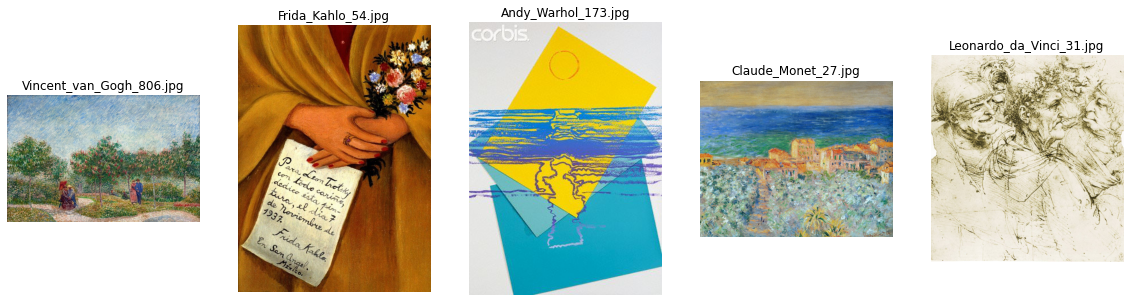

In [5]:
#Print some pantings
artist_show = ['Vincent_van_Gogh','Frida_Kahlo','Andy_Warhol','Claude_Monet','Leonardo_da_Vinci','Diego_Rivera']
fig, axes = plt.subplots(1, 5,figsize = (20,10))

import random
for i in range(5):
  artist_toshow = artist_show[i]
  choice = random.choice(os.listdir(os.path.join(dir, artist_toshow)))
  image_file = os.path.join(dir,artist_toshow, choice)
  image = plt.imread(image_file)
  axes[i].imshow(image)
  axes[i].set_title(choice)
  axes[i].axis('off')

In [6]:
# "Albrecht_Dürer" has issues because the ü
artists_dirs[0] = "Albrecht_Dürer"

In [7]:
# Get the number of paintings per artists 
num_paintings = artist[['name','paintings']]
num_paintings = num_paintings.sort_values(by = ['paintings'], ascending = False)
num_paintings['name'] = num_paintings['name'].str.replace(' ','_')
#updated_name = "Albrecht_Dürer".replace("ü", "u")
updated_name = "Albrecht_Dürer".replace(" ", "_")
num_paintings.iloc[4, 0] = updated_name

# Beacuse some artists hava more paintings than others, we calculate weights for each class
num_paintings['class_weight'] = num_paintings.paintings.sum() / (num_paintings.shape[0] * num_paintings.paintings)

num_paintings = num_paintings.set_index('name')
num_paintings.head()

,paintings,class_weight
name,,
Vincent_van_Gogh,877,0.192611
Edgar_Degas,702,0.240627
Pablo_Picasso,439,0.384784
Pierre-Auguste_Renoir,336,0.502738
Albrecht_Dürer,328,0.515000


In [8]:
# Get the weights in a dictionary
class_weights = num_paintings['class_weight'].reset_index()
class_weights = class_weights['class_weight'].to_dict()
class_weights

{0: 0.19261117445838086,
 1: 0.24062678062678064,
 2: 0.38478359908883825,
 3: 0.5027380952380952,
 4: 0.515,
 5: 0.5431511254019292,
 6: 0.5804810996563574,
 7: 0.6447328244274809,
 8: 0.6522007722007722,
 9: 0.6624313725490196,
 10: 0.7067782426778243,
 11: 0.8707216494845361,
 12: 0.8752331606217617,
 13: 0.8985106382978724,
 14: 0.9081720430107527,
 15: 0.9332596685082873,
 16: 0.9878362573099415,
 17: 1.03,
 18: 1.1812587412587412,
 19: 1.1980141843971632,
 20: 1.215251798561151,
 21: 1.232992700729927,
 22: 1.2605970149253731,
 23: 1.3196875,
 24: 1.3406349206349206,
 25: 1.4076666666666666,
 26: 1.4194957983193277,
 27: 1.4437606837606838,
 28: 1.549724770642202,
 29: 1.656078431372549,
 30: 1.7062626262626264,
 31: 1.8562637362637362,
 32: 1.8768888888888888,
 33: 1.9195454545454544,
 34: 1.941609195402299,
 35: 2.010952380952381,
 36: 2.0854320987654322,
 37: 2.0854320987654322,
 38: 2.313972602739726,
 39: 2.4131428571428573,
 40: 2.4131428571428573,
 41: 2.5211940298507463,


Divide Dataset in train, validation and test

In [9]:
# Original directory with images
dir = '/content/drive/MyDrive/7 SEMESTRE/BLOQUE 2/DEEP_LEARNING/Entrega/images'

# Create new directory
base_dir = '/content/drive/MyDrive/7 SEMESTRE/BLOQUE 2/DEEP_LEARNING/Entrega/paintings'
os.mkdir(base_dir)

# Inside paintings we create 3 directories for train, validation and test
dir_train = os.path.join(base_dir,'train')
os.mkdir(dir_train)
dir_val = os.path.join(base_dir,'val')
os.mkdir(dir_val)
dir_test = os.path.join(base_dir,'test')
os.mkdir(dir_test)

# Inside of each train, val and test directories, one more for each artist
for i in range(len(artists_dirs)):
  os.mkdir(os.path.join(dir_train,artists_dirs[i]))
  os.mkdir(os.path.join(dir_val,artists_dirs[i]))
  os.mkdir(os.path.join(dir_test,artists_dirs[i]))

In [10]:
# Copy images in the diferent directories
for i in range(len(artists_dirs)):
	num = num_paintings._get_value(artists_dirs[i],'paintings')
	to_train = math.floor(num*0.64)
	to_val = math.floor(num*0.15)
	to_test = math.floor(num*0.20)
 
	fnames = ['{name}_{num}.jpg'.format(name = artists_dirs[i], num = j) for j in range (1,to_train)]
	for fname in fnames:
		src = os.path.join(os.path.join(dir,artists_dirs[i]),fname)
		dst = os.path.join(os.path.join(dir_train,artists_dirs[i]), fname)
		shutil.copyfile(src,dst)
	
	fnames = ['{name}_{num}.jpg'.format(name = artists_dirs[i], num = j) for j in range (to_train, (to_train+to_val))]
	for fname in fnames:
		src = os.path.join(os.path.join(dir,artists_dirs[i]),fname)
		dst = os.path.join(os.path.join(dir_val,artists_dirs[i]), fname)
		shutil.copyfile(src,dst)
	
	fnames = ['{name}_{num}.jpg'.format(name = artists_dirs[i], num = j) for j in range ((to_train+to_val),(to_train+to_val+to_test))]
	for fname in fnames:
		src = os.path.join(os.path.join(dir,artists_dirs[i]),fname)
		dst = os.path.join(os.path.join(dir_test,artists_dirs[i]), fname)
		shutil.copyfile(src,dst)

Data Augmentation

In [11]:
artist_name = artist['name'].to_list()

In [12]:
# Tranformations
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							#rotation_range = 40,
							#width_shift_range = 0.2,
							#height_shift_range = 0.2,
							shear_range = 0.2,
							#zoom_range = 0.2,
							horizontal_flip = True,)

val_datagen = ImageDataGenerator(1./255)

train_generator = train_datagen.flow_from_directory(
							dir_train,
							class_mode='categorical',
							target_size = (224, 224),
							batch_size = 20,
							shuffle = True,
							classes = artist_name)

val_generator = val_datagen.flow_from_directory(
							dir_val,
							class_mode='categorical',
							target_size = (224,224),
							batch_size =20,
							classes= artist_name)


Found 460 images belonging to 50 classes.
Found 108 images belonging to 50 classes.


(-0.5, 611.5, 1023.5, -0.5)

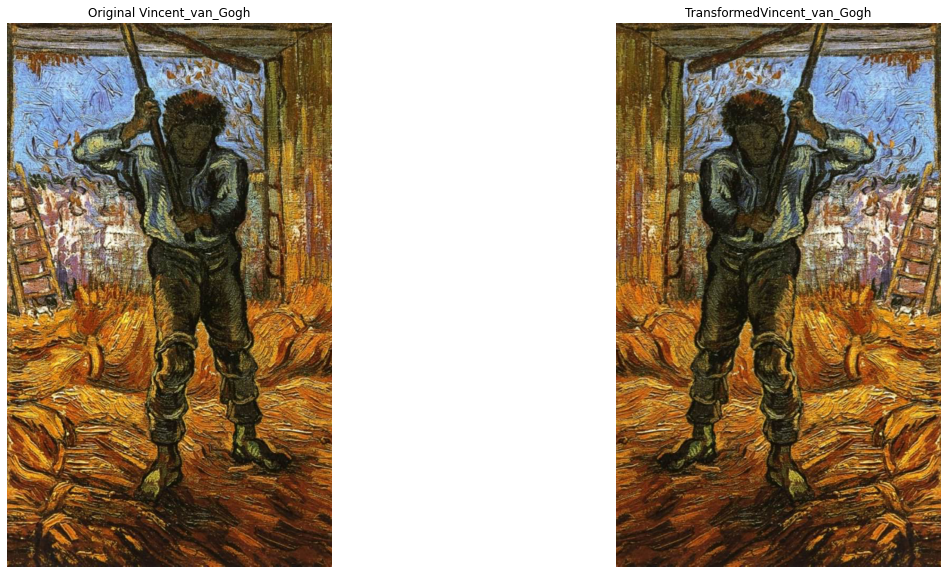

In [13]:
# Print some exameples for the transformations
fig, axes = plt.subplots(1, 2, figsize=(20,10))

name_artist = 'Vincent_van_Gogh'
choice = random.choice(os.listdir(os.path.join(dir, name_artist)))
image_file = os.path.join(dir,name_artist, choice)

image = plt.imread(image_file)
axes[0].imshow(image)
axes[0].set_title("Original " + name_artist)
axes[0].axis('off')

trans_image = train_datagen.random_transform(image)
axes[1].imshow(trans_image)
axes[1].set_title("Transformed" + name_artist)
axes[1].axis('off')

Model

In [14]:
# Using transferlearning with the model ResNet50 with the imagenet weights
base = ResNet50(weights='imagenet', 
                include_top=False, 
                input_shape=(224,224,3))

# Indicating that the basemodel will be "frozen"
base.trainable = False

# Create model
model = models.Sequential()
# add the base
model.add(base)
# add a flatten layer
model.add(layers.Flatten())
# add a dense layer
model.add(layers.Dense(256,activation='relu'))
# add the clasification layer
model.add(layers.Dense(50,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 50)                12850     
                                                                 
Total params: 49,290,930
Trainable params: 25,703,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
# compile model, with categorical_crossentropy as a loss function and Adam as a optimizer
model.compile(loss='categorical_crossentropy',
						optimizer=optimizers.Adam(lr=0.0001),
						metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

# Train the model
history = model.fit_generator(train_generator, 
				steps_per_epoch = STEP_SIZE_TRAIN,  
				epochs =15, 
				validation_data= val_generator, 
				validation_steps = STEP_SIZE_VALID,
        class_weight = class_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
23/23 [==============================] - 79s 3s/step - loss: 1.8246 - acc: 0.6913 - val_loss: 10.9126 - val_acc: 0.0600
Epoch 2/15
23/23 [==============================] - 78s 3s/step - loss: 1.7885 - acc: 0.6978 - val_loss: 10.5683 - val_acc: 0.0700
Epoch 3/15
23/23 [==============================] - 81s 3s/step - loss: 1.7677 - acc: 0.6870 - val_loss: 11.3369 - val_acc: 0.0800
Epoch 4/15
23/23 [==============================] - 77s 3s/step - loss: 1.6196 - acc: 0.7261 - val_loss: 11.1899 - val_acc: 0.0700
Epoch 5/15
23/23 [==============================] - 78s 3s/step - loss: 1.7463 - acc: 0.6696 - val_loss: 11.4250 - val_acc: 0.0800
Epoch 6/15
23/23 [==============================] - 80s 3s/step - loss: 1.5674 - acc: 0.7413 - val_loss: 12.3462 - val_acc: 0.0600
Epoch 7/15
23/23 [==============================] - 77s 3s/step - loss: 1.4715 - acc: 0.7522 - val_loss: 11.8664 - val_acc: 0.0800
Epoch 8/15
23/23 [==============================] - 80s 3s/step - loss: 1.5440 - ac

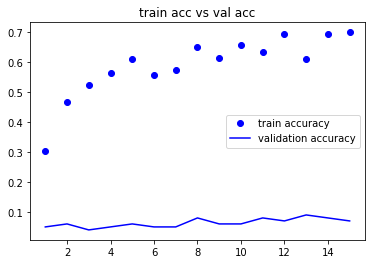

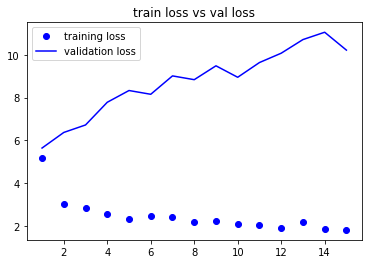

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

The model clearly is overfitting, we can fix this by changing the imperparameters of the model, add more dense layers, etc.

In [19]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
							dir_test,
							class_mode='categorical',
							target_size = (224,224),
							batch_size =20,
							classes= artist_name)
test_loss, test_acc = model.evaluate(test_generator)
print('\ntest acc :\n', test_acc)

Found 144 images belonging to 50 classes.


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


8/8 [==============================] - 19s 2s/step - loss: 11.9500 - acc: 0.1389

test acc :
 0.1388888955116272
